In [1]:
import tensorflow as tf

def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)    

In [2]:
import re

In [3]:
select_gpu(2)
sequence_length = 128
epochs = 15
model_name = 'bert-chinese'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [4]:
def txt_to_list(path, sequence_length):
    with open(path, 'r') as f:
        txt = str(f.read())
    txt_list = txt.split('\n')
    text_label_list = list()
    tmp = list()
    for line in txt_list:
        if line == '--------------------':
            text_label_list.append(tmp)
            tmp = list()
            continue
        if line == '':
            continue
        tmp.append(line)
    x = list()
    y = list()
    for text_label in text_label_list:
        text = text_label[0]
#         text_list = [i for i in text]
        label = text_label[2:]
        label_list = ['O' for i in range(len(text))]
        for i in label:
            entity = i.split('\t')
            if int(entity[1]) > int(entity[2]):
                continue
#                 print(entity)            
            b = int(entity[1])
            label_list[b] = 'B-{}'.format(entity[-1])
            for j in range(int(entity[1])+1, int(entity[2])):
                label_list[j] = 'I-{}'.format(entity[-1])
        for i, j in enumerate(text):
            if j == '，' or j == '。' or j == '？':
                label_list[i] = j
        
        text_list = re.split('\uff0c|\u3002|\uff1f', text)
        for sentence in text_list:
#             while len(sentence) < sequence_length:
#                 sentence += 'O'
#             if len(sentence) > sequence_length:
#                 sentence = sentence[:sequence_length]
            x.append([i for i in sentence])
            
        tmp = list()
        for i in label_list:
            if i == '，' or i == '。' or i == '？':
#                 while len(tmp) < sequence_length:
#                     tmp.append('O')
#                 if len(tmp) > sequence_length:
#                     tmp = tmp[:sequence_length]
                y.append(tmp)
                tmp = list()
            else:
                tmp.append(i)
        y.append(label_list)
    return [x, y]

In [5]:
x1, y1 = txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage1/SampleData_deid.txt', sequence_length)

In [6]:
x2, y2 = txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage2/train_1_update.txt', sequence_length)

In [7]:
x4, y4 = txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage4/train_2.txt', sequence_length)

In [8]:
x = x1 + x2 + x4
y = y1 + y2 + y4
print(len(x))
print(len(y))

76508
76508


In [9]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))
print(len(test_x), len(test_y))

48964 48964
12242 12242
15302 15302


In [10]:
import kashgari
from kashgari.tasks.labeling import BiLSTM_CRF_Model
from kashgari.embeddings import BertEmbedding
kashgari.config.use_cudnn_cell = True
embed_path = '/home/Danny/pretrain_model/{}'.format(model_name)
bert_embed = BertEmbedding(embed_path, sequence_length=sequence_length)
model = BiLSTM_CRF_Model(bert_embed)
history = model.fit(train_x,
                    train_y,
                    valid_x,
                    valid_y,
                    epochs=epochs,
                    batch_size=256,
                   )

2020-12-03 14:26:44,709 [DEBUG] kashgari - ------------------------------------------------
2020-12-03 14:26:44,710 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-03 14:26:44,710 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/bert-chinese/bert_config.json
2020-12-03 14:26:44,710 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/bert-chinese/vocab.txt
2020-12-03 14:26:44,710 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/bert-chinese/bert_model.ckpt
2020-12-03 14:26:44,711 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[

Epoch 1/15
191/191 [==============================] - 43s 225ms/step - loss: 0.7698 - accuracy: 0.9651 - val_loss: 22.7894 - val_accuracy: 0.9853
Epoch 2/15
191/191 [==============================] - 39s 204ms/step - loss: 0.2149 - accuracy: 0.9859 - val_loss: 22.5677 - val_accuracy: 0.9887
Epoch 3/15
191/191 [==============================] - 39s 206ms/step - loss: 0.1643 - accuracy: 0.9883 - val_loss: 22.3914 - val_accuracy: 0.9899
Epoch 4/15
191/191 [==============================] - 39s 207ms/step - loss: 0.1342 - accuracy: 0.9897 - val_loss: 22.1866 - val_accuracy: 0.9909
Epoch 5/15
191/191 [==============================] - 39s 207ms/step - loss: 0.1146 - accuracy: 0.9910 - val_loss: 22.0228 - val_accuracy: 0.9914
Epoch 6/15
191/191 [==============================] - 40s 207ms/step - loss: 0.0985 - accuracy: 0.9919 - val_loss: 21.8264 - val_accuracy: 0.9912
Epoch 7/15
191/191 [==============================] - 40s 207ms/step - loss: 0.0850 - accuracy: 0.9925 - val_loss: 21.6555 -

In [11]:
model.evaluate(test_x, test_y)
model_path = 'model/{}-epoch-{}'.format(model_name, epochs)
model.save(model_path)

2020-12-03 14:37:04,380 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 72
2020-12-03 14:37:04,476 [DEBUG] kashgari - predict seq_length: None, input: (2, 15302, 72)


479/479 [==============================] - 44s 91ms/step


2020-12-03 14:37:51,813 [DEBUG] kashgari - predict output: (15302, 72)
2020-12-03 14:37:51,814 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]



                precision    recall  f1-score   support

      location     0.9302    0.8791    0.9040        91
         money     0.6452    0.7692    0.7018        52
          name     0.9341    0.8500    0.8901       100
          time     0.8092    0.8302    0.8196       848
      med_exam     0.8369    0.8429    0.8399       140
    profession     0.6667    0.4444    0.5333         9
clinical_event     0.3333    0.2500    0.2857         4
        family     0.7222    0.7647    0.7429        17
  organization     0.0000    0.0000    0.0000         3
            ID     1.0000    0.5000    0.6667         8
       contact     0.6154    0.6154    0.6154        13
     education     0.0000    0.0000    0.0000         1

     micro avg     0.8168    0.8219    0.8194      1286
     macro avg     0.8169    0.8219    0.8182      1286



2020-12-03 14:38:00,795 [INFO] kashgari - model saved to /home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese-epoch-15


'/home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese-epoch-15'

In [12]:
from matplotlib import pyplot as plt

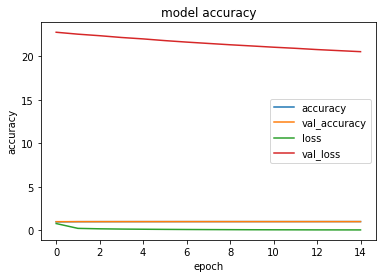

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [14]:
import pandas as pd
df = pd.read_csv('/home/Danny/AI-CUP-2020/datasets/stage4/development_2.csv')
df

,Unnamed: 0,article_id,text
0,0,0,醫師：這個要電腦看才有辦法，這是嚴重或一般的。民眾：這是沒關係啦。醫師：沒關係齁。民眾：他一...
1,1,1,醫師：就照舊這樣子。阿這一定要跟你講一下。家屬：沒關係啊。醫師：阿最近好嗎？民眾：都正常。醫...
2,2,2,醫師：就照這樣，我們就照這樣問診這樣而已啦，阿最近我們8月17號有抽血。家屬：對上上個禮拜。...
3,3,3,醫師：最近有怎麼樣嗎？民眾：都一樣欸。醫師：會痛還是怎麼樣嗎？民眾：都一樣。醫師：有發燒或是...
4,4,4,民眾：前一次是6月14號。醫師：嗯，14。民眾：13還是14。醫師：我看一下14啊，13和1...
...,...,...,...
65,65,65,個管師：來坐這裡。民眾：好，坐這裡嗎？好，靠你那麼近？個管師：靠我近一點好啊，不好嗎？會讓你...
66,66,66,個管師：好喘……哈哈哈哈。民眾：哈哈。個管師：好。小明這個月還好嗎？民眾：很好啊。個管師：很...
67,67,67,個管師：所以你是去篩檢的時候……民眾：恩。個管師：你去篩檢的時候然後許小姐跟你說你可以來這邊...
68,68,68,個管師：好喔，過去這一個月還好嗎？民眾：恩，還可以。個管師：那今天是請假？民眾：沒有，晚上上...


In [15]:
def predict_NER(model, text, sequence_length):
    x_list = list()
    while len(text) > sequence_length:
        x_list.append([i for i in text[:sequence_length]])
        text = text[sequence_length:]        
    x_list.append([i for i in text[:sequence_length]])
    y_list = model.predict(x_list)
    merge_list = list()
    for i in y_list:
        for j in i:
            merge_list.append(j)
    return merge_list

In [16]:
def output_NER(article_id, text, y):
    output = str()
    flag = False
    for i, j in enumerate(y):
        if j != 'O':
            if j[0] == 'B':
                start_position = i
                entity_type = j.split('-')[-1]
                flag = True
        elif j == 'O' and flag == True:
            end_position = i
            flag = False
            entity_text = text[start_position: end_position]
            output += '{}\t{}\t{}\t{}\t{}\n'.format(article_id, start_position, end_position, entity_text, entity_type)  
    return output

In [17]:
output="article_id\tstart_position\tend_position\tentity_text\tentity_type\n"
for article_id, text in zip(df['article_id'], df['text']):
    y = predict_NER(model, text, sequence_length)
    output += output_NER(article_id, text, y)

2020-12-03 14:38:01,126 [DEBUG] kashgari - predict seq_length: None, input: (2, 27, 130)


1/1 [==============================] - 0s 916us/step


2020-12-03 14:38:04,305 [DEBUG] kashgari - predict output: (27, 130)
2020-12-03 14:38:04,306 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 [ 0 10  7 ...  1  1  0]
 ...
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  1]]
2020-12-03 14:38:04,308 [DEBUG] kashgari - predict seq_length: None, input: (2, 7, 130)


1/1 [==============================] - 0s 763us/step


2020-12-03 14:38:04,405 [DEBUG] kashgari - predict output: (7, 130)
2020-12-03 14:38:04,406 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1 10  7  7  1  1  1  1 10  7  7  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

1/1 [==============================] - 0s 740us/step


2020-12-03 14:38:04,525 [DEBUG] kashgari - predict output: (12, 130)
2020-12-03 14:38:04,526 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 7 7 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:04,528 [DEBUG] kashgari - predict seq_length: None, input: (2, 26, 130)


1/1 [==============================] - 0s 884us/step


2020-12-03 14:38:04,684 [DEBUG] kashgari - predict output: (26, 130)
2020-12-03 14:38:04,685 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 4 1 0]
 [0 6 4 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:04,686 [DEBUG] kashgari - predict seq_length: None, input: (2, 17, 130)


1/1 [==============================] - 0s 823us/step


2020-12-03 14:38:04,823 [DEBUG] kashgari - predict output: (17, 130)
2020-12-03 14:38:04,823 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:04,825 [DEBUG] kashgari - predict seq_length: None, input: (2, 23, 130)


1/1 [==============================] - 0s 819us/step


2020-12-03 14:38:04,976 [DEBUG] kashgari - predict output: (23, 130)
2020-12-03 14:38:04,977 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:04,979 [DEBUG] kashgari - predict seq_length: None, input: (2, 13, 130)


1/1 [==============================] - 0s 975us/step


2020-12-03 14:38:05,097 [DEBUG] kashgari - predict output: (13, 130)
2020-12-03 14:38:05,098 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:05,099 [DEBUG] kashgari - predict seq_length: None, input: (2, 9, 130)


1/1 [==============================] - 0s 865us/step


2020-12-03 14:38:05,194 [DEBUG] kashgari - predict output: (9, 130)
2020-12-03 14:38:05,195 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:05,196 [DEBUG] kashgari - predict seq_length: None, input: (2, 8, 130)


1/1 [==============================] - 0s 785us/step


2020-12-03 14:38:05,291 [DEBUG] kashgari - predict output: (8, 130)
2020-12-03 14:38:05,292 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 8 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:05,293 [DEBUG] kashgari - predict seq_length: None, input: (2, 6, 130)


1/1 [==============================] - 0s 910us/step


2020-12-03 14:38:05,390 [DEBUG] kashgari - predict output: (6, 130)
2020-12-03 14:38:05,393 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  6  4  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  6
   4  4  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

1/1 [==============================] - 0s 891us/step


2020-12-03 14:38:05,483 [DEBUG] kashgari - predict output: (5, 130)
2020-12-03 14:38:05,484 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  10  7  1  1  1  1  1 10  7  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  6  4  4  4  1  1  1  1  1  1  1  1  1  1  1
   6  4  4  1  1  1  6  4  4  4  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  6  4  4  4  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  6  4  4  4  1  1  1  1  1  1  1  1  

1/1 [==============================] - 0s 1ms/step


2020-12-03 14:38:05,616 [DEBUG] kashgari - predict output: (19, 130)
2020-12-03 14:38:05,616 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:05,618 [DEBUG] kashgari - predict seq_length: None, input: (2, 8, 130)


1/1 [==============================] - 0s 807us/step


2020-12-03 14:38:05,711 [DEBUG] kashgari - predict output: (8, 130)
2020-12-03 14:38:05,712 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:05,713 [DEBUG] kashgari - predict seq_length: None, input: (2, 10, 130)


1/1 [==============================] - 0s 643us/step


2020-12-03 14:38:05,815 [DEBUG] kashgari - predict output: (10, 130)
2020-12-03 14:38:05,815 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ... 10  7  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 ...
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  1]]
2020-12-03 14:38:05,816 [DEBUG] kashgari - predict seq_length: None, input: (2, 11, 130)


1/1 [==============================] - 0s 648us/step


2020-12-03 14:38:05,927 [DEBUG] kashgari - predict output: (11, 130)
2020-12-03 14:38:05,928 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 4 4 4]]
2020-12-03 14:38:05,930 [DEBUG] kashgari - predict seq_length: None, input: (2, 16, 130)


1/1 [==============================] - 0s 676us/step


2020-12-03 14:38:06,058 [DEBUG] kashgari - predict output: (16, 130)
2020-12-03 14:38:06,058 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:06,059 [DEBUG] kashgari - predict seq_length: None, input: (2, 6, 130)


1/1 [==============================] - 0s 848us/step


2020-12-03 14:38:06,155 [DEBUG] kashgari - predict output: (6, 130)
2020-12-03 14:38:06,157 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  6  4  4  4  1  1  1  1  1  1  1  1  1  1  1  6  4  4  4  1
   1  1  1  1  1  1  1  1  1  1  1  1  6  4  4  4  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  6  4  4  4  1  1  1  1  1  1  1  1  1  1  1  1  1  

1/1 [==============================] - 0s 717us/step


2020-12-03 14:38:06,315 [DEBUG] kashgari - predict output: (25, 130)
2020-12-03 14:38:06,315 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:06,317 [DEBUG] kashgari - predict seq_length: None, input: (2, 6, 130)


1/1 [==============================] - 0s 650us/step


2020-12-03 14:38:06,406 [DEBUG] kashgari - predict output: (6, 130)
2020-12-03 14:38:06,408 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  6  4
   4  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1 10  7  7  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1 10  7  7  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

2/2 [==============================] - 0s 54ms/step


2020-12-03 14:38:06,699 [DEBUG] kashgari - predict output: (48, 130)
2020-12-03 14:38:06,699 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:06,703 [DEBUG] kashgari - predict seq_length: None, input: (2, 37, 130)


2/2 [==============================] - 0s 34ms/step


2020-12-03 14:38:06,964 [DEBUG] kashgari - predict output: (37, 130)
2020-12-03 14:38:06,964 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:06,967 [DEBUG] kashgari - predict seq_length: None, input: (2, 28, 130)


1/1 [==============================] - 0s 726us/step


2020-12-03 14:38:07,132 [DEBUG] kashgari - predict output: (28, 130)
2020-12-03 14:38:07,132 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 ...
 [ 0  1  1 ... 12  9  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  1]]
2020-12-03 14:38:07,135 [DEBUG] kashgari - predict seq_length: None, input: (2, 31, 130)


1/1 [==============================] - 0s 771us/step


2020-12-03 14:38:07,309 [DEBUG] kashgari - predict output: (31, 130)
2020-12-03 14:38:07,310 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:07,312 [DEBUG] kashgari - predict seq_length: None, input: (2, 15, 130)


1/1 [==============================] - 0s 698us/step


2020-12-03 14:38:07,434 [DEBUG] kashgari - predict output: (15, 130)
2020-12-03 14:38:07,435 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 4 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:07,436 [DEBUG] kashgari - predict seq_length: None, input: (2, 9, 130)


1/1 [==============================] - 0s 695us/step


2020-12-03 14:38:07,545 [DEBUG] kashgari - predict output: (9, 130)
2020-12-03 14:38:07,545 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:07,546 [DEBUG] kashgari - predict seq_length: None, input: (2, 10, 130)


1/1 [==============================] - 0s 666us/step


2020-12-03 14:38:07,647 [DEBUG] kashgari - predict output: (10, 130)
2020-12-03 14:38:07,647 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:07,650 [DEBUG] kashgari - predict seq_length: None, input: (2, 21, 130)


1/1 [==============================] - 0s 921us/step


2020-12-03 14:38:07,795 [DEBUG] kashgari - predict output: (21, 130)
2020-12-03 14:38:07,796 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:07,798 [DEBUG] kashgari - predict seq_length: None, input: (2, 5, 130)


1/1 [==============================] - 0s 803us/step


2020-12-03 14:38:07,888 [DEBUG] kashgari - predict output: (5, 130)
2020-12-03 14:38:07,889 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1 12  9  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1 12  9  1  1  1  1  1  1  1  1  1  1  1  1  1 12  9  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1 12  9  6  4  1  1  1  1  1  1  1  

1/1 [==============================] - 0s 798us/step


2020-12-03 14:38:08,036 [DEBUG] kashgari - predict output: (21, 130)
2020-12-03 14:38:08,037 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:08,039 [DEBUG] kashgari - predict seq_length: None, input: (2, 21, 130)


1/1 [==============================] - 0s 792us/step


2020-12-03 14:38:08,183 [DEBUG] kashgari - predict output: (21, 130)
2020-12-03 14:38:08,184 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 6 4 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:08,186 [DEBUG] kashgari - predict seq_length: None, input: (2, 14, 130)


1/1 [==============================] - 0s 730us/step


2020-12-03 14:38:08,298 [DEBUG] kashgari - predict output: (14, 130)
2020-12-03 14:38:08,298 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 6 4 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:08,300 [DEBUG] kashgari - predict seq_length: None, input: (2, 17, 130)


1/1 [==============================] - 0s 711us/step


2020-12-03 14:38:08,433 [DEBUG] kashgari - predict output: (17, 130)
2020-12-03 14:38:08,433 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 4 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:08,436 [DEBUG] kashgari - predict seq_length: None, input: (2, 23, 130)


1/1 [==============================] - 0s 819us/step


2020-12-03 14:38:08,580 [DEBUG] kashgari - predict output: (23, 130)
2020-12-03 14:38:08,580 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:08,582 [DEBUG] kashgari - predict seq_length: None, input: (2, 8, 130)


1/1 [==============================] - 0s 605us/step


2020-12-03 14:38:08,692 [DEBUG] kashgari - predict output: (8, 130)
2020-12-03 14:38:08,693 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:08,695 [DEBUG] kashgari - predict seq_length: None, input: (2, 37, 130)


2/2 [==============================] - 0s 33ms/step


2020-12-03 14:38:08,938 [DEBUG] kashgari - predict output: (37, 130)
2020-12-03 14:38:08,939 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:08,942 [DEBUG] kashgari - predict seq_length: None, input: (2, 40, 130)


2/2 [==============================] - 0s 39ms/step


2020-12-03 14:38:09,199 [DEBUG] kashgari - predict output: (40, 130)
2020-12-03 14:38:09,200 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 ...
 [ 0  1  1 ... 11  1  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  1]]
2020-12-03 14:38:09,202 [DEBUG] kashgari - predict seq_length: None, input: (2, 8, 130)


1/1 [==============================] - 0s 667us/step


2020-12-03 14:38:09,296 [DEBUG] kashgari - predict output: (8, 130)
2020-12-03 14:38:09,296 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:09,298 [DEBUG] kashgari - predict seq_length: None, input: (2, 12, 130)


1/1 [==============================] - 0s 611us/step


2020-12-03 14:38:09,409 [DEBUG] kashgari - predict output: (12, 130)
2020-12-03 14:38:09,410 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:09,411 [DEBUG] kashgari - predict seq_length: None, input: (2, 6, 130)


1/1 [==============================] - 0s 658us/step


2020-12-03 14:38:09,498 [DEBUG] kashgari - predict output: (6, 130)
2020-12-03 14:38:09,500 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 12
   9  1  1  1  1  1  1  1  1  1  1  1  1 12  9  1  1  1  1  1  1 12  9  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  6  1  1  6  4  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  6  4  4  4  1  1  1  1  1  1  1  1  1  1  1
   1  1 12  9  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

1/1 [==============================] - 0s 690us/step


2020-12-03 14:38:09,631 [DEBUG] kashgari - predict output: (18, 130)
2020-12-03 14:38:09,631 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:09,632 [DEBUG] kashgari - predict seq_length: None, input: (2, 9, 130)


1/1 [==============================] - 0s 686us/step


2020-12-03 14:38:09,731 [DEBUG] kashgari - predict output: (9, 130)
2020-12-03 14:38:09,731 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:09,733 [DEBUG] kashgari - predict seq_length: None, input: (2, 16, 130)


1/1 [==============================] - 0s 767us/step


2020-12-03 14:38:09,860 [DEBUG] kashgari - predict output: (16, 130)
2020-12-03 14:38:09,861 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:09,863 [DEBUG] kashgari - predict seq_length: None, input: (2, 24, 130)


1/1 [==============================] - 0s 678us/step


2020-12-03 14:38:10,024 [DEBUG] kashgari - predict output: (24, 130)
2020-12-03 14:38:10,025 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:10,026 [DEBUG] kashgari - predict seq_length: None, input: (2, 13, 130)


1/1 [==============================] - 0s 906us/step


2020-12-03 14:38:10,143 [DEBUG] kashgari - predict output: (13, 130)
2020-12-03 14:38:10,144 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:10,146 [DEBUG] kashgari - predict seq_length: None, input: (2, 15, 130)


1/1 [==============================] - 0s 708us/step


2020-12-03 14:38:10,268 [DEBUG] kashgari - predict output: (15, 130)
2020-12-03 14:38:10,269 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 ...
 [ 0  1  1 ... 12  9  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  1]]
2020-12-03 14:38:10,270 [DEBUG] kashgari - predict seq_length: None, input: (2, 10, 130)


1/1 [==============================] - 0s 757us/step


2020-12-03 14:38:10,381 [DEBUG] kashgari - predict output: (10, 130)
2020-12-03 14:38:10,381 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 6 ... 1 1 1]]
2020-12-03 14:38:10,386 [DEBUG] kashgari - predict seq_length: None, input: (2, 43, 130)


2/2 [==============================] - 0s 46ms/step


2020-12-03 14:38:10,663 [DEBUG] kashgari - predict output: (43, 130)
2020-12-03 14:38:10,664 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 4 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:10,667 [DEBUG] kashgari - predict seq_length: None, input: (2, 19, 130)


1/1 [==============================] - 0s 806us/step


2020-12-03 14:38:10,796 [DEBUG] kashgari - predict output: (19, 130)
2020-12-03 14:38:10,797 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:10,799 [DEBUG] kashgari - predict seq_length: None, input: (2, 16, 130)


1/1 [==============================] - 0s 697us/step


2020-12-03 14:38:10,928 [DEBUG] kashgari - predict output: (16, 130)
2020-12-03 14:38:10,929 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:10,931 [DEBUG] kashgari - predict seq_length: None, input: (2, 38, 130)


2/2 [==============================] - 0s 35ms/step


2020-12-03 14:38:11,183 [DEBUG] kashgari - predict output: (38, 130)
2020-12-03 14:38:11,184 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 6 4 0]
 [0 6 4 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 6 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:11,188 [DEBUG] kashgari - predict seq_length: None, input: (2, 32, 130)


1/1 [==============================] - 0s 743us/step


2020-12-03 14:38:13,652 [DEBUG] kashgari - predict output: (32, 130)
2020-12-03 14:38:13,653 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 0]
 [0 1 6 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:13,656 [DEBUG] kashgari - predict seq_length: None, input: (2, 48, 130)


2/2 [==============================] - 0s 55ms/step


2020-12-03 14:38:13,943 [DEBUG] kashgari - predict output: (48, 130)
2020-12-03 14:38:13,944 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:13,947 [DEBUG] kashgari - predict seq_length: None, input: (2, 14, 130)


1/1 [==============================] - 0s 726us/step


2020-12-03 14:38:14,061 [DEBUG] kashgari - predict output: (14, 130)
2020-12-03 14:38:14,062 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:14,063 [DEBUG] kashgari - predict seq_length: None, input: (2, 9, 130)


1/1 [==============================] - 0s 616us/step


2020-12-03 14:38:14,164 [DEBUG] kashgari - predict output: (9, 130)
2020-12-03 14:38:14,165 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:14,166 [DEBUG] kashgari - predict seq_length: None, input: (2, 5, 130)


1/1 [==============================] - 0s 812us/step


2020-12-03 14:38:14,251 [DEBUG] kashgari - predict output: (5, 130)
2020-12-03 14:38:14,253 [DEBUG] kashgari - predict output argmax: [[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 4 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

1/1 [==============================] - 0s 925us/step


2020-12-03 14:38:14,368 [DEBUG] kashgari - predict output: (11, 130)
2020-12-03 14:38:14,368 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:14,370 [DEBUG] kashgari - predict seq_length: None, input: (2, 19, 130)


1/1 [==============================] - 0s 679us/step


2020-12-03 14:38:14,509 [DEBUG] kashgari - predict output: (19, 130)
2020-12-03 14:38:14,509 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 6 0]
 [0 6 4 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:14,511 [DEBUG] kashgari - predict seq_length: None, input: (2, 17, 130)


1/1 [==============================] - 0s 824us/step


2020-12-03 14:38:14,642 [DEBUG] kashgari - predict output: (17, 130)
2020-12-03 14:38:14,643 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:14,644 [DEBUG] kashgari - predict seq_length: None, input: (2, 7, 130)


1/1 [==============================] - 0s 677us/step


2020-12-03 14:38:14,743 [DEBUG] kashgari - predict output: (7, 130)
2020-12-03 14:38:14,745 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1 10  7  7  7  7  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  6  4  4  1  1  6  4  4  1  1  1
   1  1  1  1  1  1  6  4  1  6  4  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

1/1 [==============================] - 0s 706us/step


2020-12-03 14:38:14,875 [DEBUG] kashgari - predict output: (17, 130)
2020-12-03 14:38:14,876 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 9 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:14,878 [DEBUG] kashgari - predict seq_length: None, input: (2, 22, 130)


1/1 [==============================] - 0s 927us/step


2020-12-03 14:38:15,024 [DEBUG] kashgari - predict output: (22, 130)
2020-12-03 14:38:15,025 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:15,028 [DEBUG] kashgari - predict seq_length: None, input: (2, 20, 130)


1/1 [==============================] - 0s 914us/step


2020-12-03 14:38:15,168 [DEBUG] kashgari - predict output: (20, 130)
2020-12-03 14:38:15,169 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:15,171 [DEBUG] kashgari - predict seq_length: None, input: (2, 8, 130)


1/1 [==============================] - 0s 854us/step


2020-12-03 14:38:15,270 [DEBUG] kashgari - predict output: (8, 130)
2020-12-03 14:38:15,270 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:15,272 [DEBUG] kashgari - predict seq_length: None, input: (2, 3, 130)


1/1 [==============================] - 0s 915us/step


2020-12-03 14:38:15,360 [DEBUG] kashgari - predict output: (3, 130)
2020-12-03 14:38:15,361 [DEBUG] kashgari - predict output argmax: [[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 4 4 4 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 6 4 1 1 6 4 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 6 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 4 4 4 1 1 1 1 1 1 6 4 4 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]]
2020-12-03 14:38:15,362 [DEBUG] kashgari - predict seq_len

1/1 [==============================] - 0s 805us/step


2020-12-03 14:38:15,468 [DEBUG] kashgari - predict output: (10, 130)
2020-12-03 14:38:15,469 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:15,471 [DEBUG] kashgari - predict seq_length: None, input: (2, 15, 130)


1/1 [==============================] - 0s 884us/step


2020-12-03 14:38:15,593 [DEBUG] kashgari - predict output: (15, 130)
2020-12-03 14:38:15,594 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 6 4 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:15,595 [DEBUG] kashgari - predict seq_length: None, input: (2, 6, 130)


1/1 [==============================] - 0s 786us/step


2020-12-03 14:38:15,692 [DEBUG] kashgari - predict output: (6, 130)
2020-12-03 14:38:15,695 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1 13  8  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  6  4  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  6  4  1  1  1  

1/1 [==============================] - 0s 957us/step


2020-12-03 14:38:15,814 [DEBUG] kashgari - predict output: (14, 130)
2020-12-03 14:38:15,815 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 14:38:15,817 [DEBUG] kashgari - predict seq_length: None, input: (2, 6, 130)


1/1 [==============================] - 0s 824us/step


2020-12-03 14:38:15,911 [DEBUG] kashgari - predict output: (6, 130)
2020-12-03 14:38:15,913 [DEBUG] kashgari - predict output argmax: [[0 1 1 1 1 1 1 1 1 1 6 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 4 1 1
  1 1 1 1 1 1 1 1 6 4 1 1 1 1 1 1 1 6 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

1/1 [==============================] - 0s 662us/step


2020-12-03 14:38:16,041 [DEBUG] kashgari - predict output: (15, 130)
2020-12-03 14:38:16,042 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]


In [18]:
print(output)

article_id	start_position	end_position	entity_text	entity_type
0	256	258	25	med_exam
0	273	276	李醫生	name
0	320	322	25	med_exam
0	326	328	25	med_exam
0	370	372	晚上	time
0	400	403	11點	time
0	615	619	11點多	time
0	644	647	這兩天	time
0	817	819	晚上	time
0	836	838	那天	time
0	1168	1172	7月21	time
0	1571	1574	10多	time
0	1809	1812	10多	time
0	2200	2203	13號	time
0	2214	2217	15天	time
0	2226	2228	3天	time
0	2259	2263	一個禮拜	time
0	2319	2322	禮拜一	time
0	2332	2335	禮拜一	time
0	2372	2375	前幾天	time
0	2555	2558	皇后區	location
0	2615	2617	阿姨	family
0	2624	2628	下下禮拜	time
0	2735	2740	布魯克林區	location
0	2752	2755	皇后區	location
0	2760	2763	皇后區	location
0	2767	2770	皇后區	location
0	2774	2777	皇后區	location
0	2780	2782	北區	location
0	2807	2810	下禮拜	time
0	3029	3031	昨天	time
0	3067	3070	下禮拜	time
0	3340	3343	下禮拜	time
1	59	62	108	med_exam
1	66	69	108	med_exam
1	457	460	五月中	time
1	671	674	三個月	time
2	27	32	8月17號	time
2	40	45	上上個禮拜	time
2	53	56	110	med_exam
2	85	88	110	med_exam
2	111	114	6.0	med_exam
2	253	256	126	med_exam
2	279	282	2年前	time
2

In [19]:
output_path='output/{}-epo-{}.tsv'.format(model_name, epochs)
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(output)